# 3.5 Agent의 히스토리를 관리하는 방법

- 에이전트의 히스토리를 관리해서 대화를 이어나가는 방법을 알아봅니다
- 히스토리를 관리를 위해 `checkpointer`를 사용합니다.
- `checkpointer`는 두 가지 방법을 제공합니다
    - 메모리에 저장하는 방법
    - 데이터베이스에 저장하는 방법
- 이 강의에서는 메모리에 저장하는 방법을 알아봅니다
    - 다양한 [`checkpointer`](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries)를 확인해보세요

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment='gpt-4o-2024-11-20',
    api_version='2024-08-01-preview',   
)

small_llm = AzureChatOpenAI(
    azure_deployment='gpt-4o-mini-2024-07-18',
    api_version='2024-08-01-preview',
)

In [4]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [5]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [6]:
from langchain_google_community import GmailToolkit

from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()


In [7]:
gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x127d15130>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x127d15130>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x127d15130>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x127d15130>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x127d15130>)]

In [8]:
from langchain.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"],
)

In [9]:
import os

from langchain_chroma import Chroma
from langchain_openai import AzureOpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool

embedding_function = AzureOpenAIEmbeddings(
    model='text-embedding-3-large',
    azure_endpoint=os.getenv('AZURE_OPENAI_EMBEDDING_ENDPOINT'),
    api_key=os.getenv('AZURE_OPENAI_EMBEDDING_API_KEY')
)
vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'real_estate_tax',
    persist_directory='./real_estate_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retriever',
    description='Contains information about real estate tax up to December 2024',
)

In [10]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool, retriever_tool] + gmail_tool_list + loaded_tool_list
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [11]:
from langgraph.graph import MessagesState, StateGraph

class AgentState(MessagesState):
    summary: str

graph_builder = StateGraph(AgentState)

In [12]:
from langchain_core.messages import SystemMessage

def agent(state: AgentState) -> AgentState:
    """
    주어진 `state`에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (AgentState): 메시지 기록과 요약을 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    # 메시지와 요약을 state에서 가져옵니다.
    messages = state['messages']
    summary = state['summary']
    
    # 요약이 비어있지 않으면, 요약을 메시지 앞에 추가합니다.
    if summary != '':
        messages = [SystemMessage(content=f'Here is the summary of the earlier conversation: {summary}')] + messages
    
    # LLM과 도구를 사용하여 메시지에 대한 응답을 생성합니다.
    response = llm_with_tools.invoke(messages)
    
    # 응답 메시지를 포함하는 새로운 state를 반환합니다.
    return {'messages': [response]}

In [13]:
def summarize_messages(state: AgentState) -> AgentState:
    """
    주어진 state의 메시지를 요약합니다.

    Args:
        state (AgentState): 메시지와 요약을 포함하는 state.

    Returns:
        AgentState: 요약된 메시지를 포함하는 딕셔너리.
    """
    # state에서 메시지와 요약을 가져옵니다.
    messages = state['messages']
    summary = state['summary']
    
    # 요약 프롬프트를 생성합니다.
    summary_prompt = f'summarize this chat history below: \n\nchat_history:{messages}'
    
    # 기존 요약이 있으면, 요약을 포함한 프롬프트를 생성합니다.
    if summary != '':
        summary_prompt = f'''summarize this chat history below while looking at the summary of earlier conversations
chat_history:{messages}
summary:{summary}'''
    
    # LLM을 사용하여 요약을 생성합니다.
    summary = small_llm.invoke(summary_prompt)
    
    # 요약된 메시지를 반환합니다.
    return {'summary': summary.content}

In [14]:
from langchain_core.messages import RemoveMessage

def delete_messages(state: AgentState) -> AgentState:
    """
    주어진 state에서 오래된 메시지를 삭제합니다.

    Args:
        state (AgentState): 메시지를 포함하는 state.

    Returns:
        AgentState: 삭제된 메시지를 포함하는 새로운 state.
    """
    # state에서 메시지를 가져옵니다.
    messages = state['messages']
    # 마지막 세 개의 메시지를 제외한 나머지 메시지를 삭제합니다.
    delete_messages = [RemoveMessage(id=message.id) for message in messages[:-3]]
    # 삭제된 메시지를 포함하는 새로운 state를 반환합니다.
    return {'messages': delete_messages}

- 영상에는 수정하면서 누락된 부분입니다 (MessagesState -> AgentState)
- `should_continue`는 `summary`를 바라보지 않기 때문에 에러가 발생하지는 않습니다

In [15]:
from typing import Literal

def should_continue(state: AgentState) -> Literal['tools', 'summarize_messages']:
    """
    주어진 state에 따라 다음 단계로 진행할지를 결정합니다.

    Args:
        state (AgentState): 메시지와 도구 호출 정보를 포함하는 state.

    Returns:
        Literal['tools', 'summarize_messages']: 다음 단계로 'tools' 또는 'summarize_messages'를 반환합니다.
    """
    # state에서 메시지를 가져옵니다.
    messages = state['messages']
    # 마지막 AI 메시지를 확인합니다.
    last_ai_message = messages[-1]
    
    # 마지막 AI 메시지가 도구 호출을 포함하고 있는지 확인합니다.
    if last_ai_message.tool_calls:
        # 도구 호출이 있으면 'tools'를 반환합니다.
        return 'tools'
    
    # 도구 호출이 없으면 'summarize_messages'를 반환합니다.
    return 'summarize_messages'

- `node`를 추가하고 `edge`로 연결합니다

In [16]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node(delete_messages)
graph_builder.add_node(summarize_messages)

In [17]:
from langgraph.graph import START, END


graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', 'summarize_messages']
)
graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('summarize_messages', 'delete_messages')
graph_builder.add_edge('delete_messages', END)

- 히스토리 관리를 위해 `checkpointer`를 사용합니다
    - `MemorySaver`는 메모리에 저장하는 방법입니다


In [18]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

graph= graph_builder.compile(checkpointer=checkpointer)

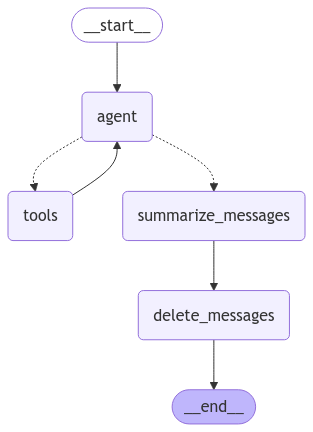

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

- `checkpointer`를 사용하는 경우, 관리를 위해 `thread_id`를 사용합니다

In [20]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'summarize_paper'
    }
}

query = 'jasonkang14@gmail.com으로 Attention Is All You Need 논문을 요약해서 이메일 초안을 작성해주세요'
for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary': ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

jasonkang14@gmail.com으로 Attention Is All You Need 논문을 요약해서 이메일 초안을 작성해주세요
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_t9mkhS5FbNxq58eshmTDVuNT)
 Call ID: call_t9mkhS5FbNxq58eshmTDVuNT
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Llama-v2 mo

In [29]:
current_message_list = graph.get_state(config).values['messages']
current_message_list

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_StP58OkRHebEV70wSxOc0lm1', 'function': {'arguments': '{"message":"안녕하세요,\\n\\n다음은 \'Attention Is All You Need\' 논문의 요약입니다:\\n\\n이 논문은 주로 대형 언어 모델(LLM)의 추론 수요가 급증함에 따라, 주의(attention) 계층의 입력 길이에 대한 복잡성을 다룹니다. 연구자들은 추론 시 MLP 및 주의 계층을 제거하는 것이 Llama-v2 모델의 성능에 미치는 영향을 조사했습니다. 그 결과, 더 깊은 주의 계층을 제거하는 것이 성능에 미치는 영향은 미미하지만, 전체 계층을 제거하는 것과 함께 최상의 속도 향상을 가져온다는 것을 발견했습니다. 예를 들어, 13B Llama2 모델에서 주의 계층의 33%를 제거하면 OpenLLM 벤치마크에서 평균 성능이 1.8% 감소하는 것으로 나타났습니다. 또한, 마지막 계층을 제외한 계층을 건너뛰면 성능이 감소하지만, 주의 계층을 건너뛰는 경우에는 예외가 있었습니다.\\n\\n추가적으로, 다양한 연구에서 주의 메커니즘을 적용한 다른 연구들도 있었습니다. 예를 들어, GLAM(Global-local Attention Module)은 이미지 검색을 위한 새로운 특징 텐서를 학습하는 방법을 제안하고, RITA는 시계열 분석을 위한 새로운 주의 메커니즘을 통해 성능을 향상시켰습니다.\\n\\n이 논문은 주의 메커니즘과 그 변형들이 다양한 문제 해결에 어떻게 기여할 수 있는지를 잘 보여줍니다.\\n\\n감사합니다.","to":["jasonkang14@gmail.com"],"subject":"Attention Is All You Need 논문 요약"}', 'name': 'create_gmail_draft'}, 'type': 'function'}], 'refusal': None}, response_metadata={

In [30]:
graph.get_state(config).values['summary']


'이메일 초안이 성공적으로 작성되었습니다. 제목은 "Attention Is All You Need 논문 요약"이며, 내용에는 논문의 요약이 포함되어 있습니다. 이메일을 보내거나 수정이 필요하시면 말씀해 주세요!'

In [23]:
# from langchain_core.messages import RemoveMessage

# for index, message in enumerate(current_message_list):
#     if index < len(current_message_list) - 1:
#         graph.update_state(config, {'messages': RemoveMessage(id=message.id)})

In [24]:
# current_message_list = graph.get_state(config).values['messages']
# current_message_list

In [31]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'summarize_paper'
    }
}

update_query = '논문의 출처 URL을 포함시켜주세요'
for chunk in graph.stream({'messages': [HumanMessage(update_query)]}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

논문의 출처 URL을 포함시켜주세요
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_TGq4glCFGBeFUr5t94D0T5eu)
 Call ID: call_TGq4glCFGBeFUr5t94D0T5eu
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Llama-v2 models. We find that dropping dreeper attention layers o

In [32]:
graph.get_state(config).values['summary']


'이메일 초안이 업데이트되어 논문의 출처 URL이 포함되었습니다. 제목은 "Attention Is All You Need 논문 요약"이며, 내용에는 논문의 요약과 함께 출처 링크가 포함되어 있습니다. 이메일을 보내거나 추가 수정이 필요하시면 말씀해 주세요!'

In [27]:
# send_query = '이메일을 전송해주세요'
# for chunk in graph.stream({'messages': [HumanMessage(send_query)]}, config=config, stream_mode='values'):
#     chunk['messages'][-1].pretty_print()